# Correlator reading 1

In [149]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [150]:
import h5py as h5 #to read the correlator
import numpy as np #to do everything
from pathlib import Path #to read the file's names
from typing import Any, Callable #to use annotations for functions
import matplotlib.pyplot as plt #to plot stuff

In [151]:
configID = "090125_180923"

basefolder = "/home/tag-e/phd/data_folders/2PointCorrelation/"
filename = basefolder + f"hadspec.{configID}.h5" # configID are these numbers in the file names

T = 48
C2pt = np.zeros(48, dtype = complex) 
with h5.File(filename, 'r') as h5f:
    C2pt = h5f[f"cfg{configID}/hspectrum/GN3x60-P/mq-0.09933/proton_3/PX0_PY0_PZ0"][()]
    type(C2pt)
    np.shape(C2pt)

numpy.ndarray

(48,)

In [152]:
p = Path(basefolder).glob('**/*')
files = [x for x in p if x.is_file()]
files[0].name

'hadspec.090125_070539.h5'

In [153]:
##### read everything

#folder with all the data
basefolder = "/home/tag-e/phd/data_folders/2PointCorrelation/"

#Path file to the data folder
p = Path(basefolder).glob('**/*')
files = [x for x in p if x.is_file()]

#number of data files (i.e. the number of gauge configurations, and for each the 2point correlator is computed)
nconf = len(files)

#Time extent of the lattice
T = 48

#array with all the 2 point correlators
corr_2p = np.empty((nconf,T),dtype=complex) # shape = (n of config, Time extent)


#we cycle through the files in the folder
for i,file in enumerate(files):

    #we grep the id of the configuration from the file name
    configID = file.name.split('.')[1]

    #we open the file
    with h5.File(basefolder+file.name, 'r') as h5f:
    
        #we store the correlator into the related array
        corr_2p[i] = h5f[f"cfg{configID}/hspectrum/GN3x60-P/mq-0.09933/proton_3/PX0_PY0_PZ0"][()]



array([ 1.67909357e-08,  9.91452419e-09,  5.42965216e-09,  2.89625567e-09,
        1.55570984e-09,  8.47191499e-10,  4.66953551e-10,  2.60329198e-10,
        1.46173171e-10,  8.26903919e-11,  4.72109702e-11,  2.71252887e-11,
        1.54293308e-11,  9.03912689e-12,  5.41950809e-12,  3.23543476e-12,
        2.01590691e-12,  1.42374332e-12,  9.22496871e-13,  4.61152165e-13,
        9.86267367e-14, -1.58268965e-13, -2.56448255e-13, -1.68655785e-13,
       -1.19307992e-13,  5.09242280e-15,  1.64777338e-13,  4.17469696e-13,
        3.55144854e-13,  2.57088308e-13,  2.30680992e-13,  1.11196640e-13,
        3.90319292e-14, -1.32722162e-14, -9.17101923e-14,  5.94047403e-14,
        4.68430416e-13,  8.59548062e-13,  1.16592525e-12,  1.42261538e-12,
        2.27532901e-12,  4.78728620e-12,  1.14918891e-11,  2.92621604e-11,
        7.66559468e-11,  2.14287295e-10,  6.37441063e-10,  1.94315268e-09])

array([ 2.13587105e-11,  2.19200131e-11,  1.64284760e-11,  1.01937544e-11,
        5.14839277e-12,  1.17484046e-12, -2.29063247e-13,  6.39906201e-15,
        7.29373623e-13,  7.82453433e-13,  7.59428149e-13,  5.95673880e-13,
        3.98477057e-13,  1.90282496e-14,  1.75665610e-13,  5.77348974e-14,
       -8.11240897e-14, -1.03160619e-13, -1.01761283e-13, -1.28855563e-13,
       -2.32664736e-13, -2.43391339e-13, -2.50018257e-13, -9.81411897e-14,
        3.02969578e-14,  9.16059406e-14,  8.73305218e-14, -7.48502527e-15,
       -8.08044197e-14, -1.62597351e-13, -7.13379062e-14,  1.11266079e-13,
        1.34583139e-13,  1.72166025e-14,  8.19641910e-15,  2.10835320e-14,
       -3.07293684e-14, -2.22863488e-13, -3.63129520e-13, -1.67943500e-13,
        7.06307703e-14,  3.47395451e-13,  7.95469161e-13,  1.07686077e-12,
        8.11279577e-13, -2.83604548e-13, -7.01237997e-13, -9.04345205e-13])

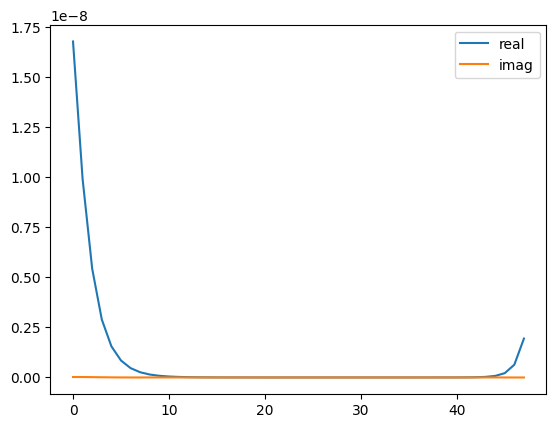

In [154]:
times=np.arange(T)
np.mean(corr_2p.real,axis=0)
np.mean(corr_2p.imag,axis=0)

plt.plot(times,np.mean(corr_2p.real,axis=0),label='real')
plt.plot(times,np.mean(corr_2p.imag,axis=0),label='imag')
plt.legend()

In [155]:
#cast to real
#corr_2p = corr_2p.real
#corr_2p = corr_2p.imag
corr_2p = np.abs(corr_2p)

In [156]:
np.shape(corr_2p)

(102, 48)

In [194]:
def jackknife(in_array: np.ndarray, observable: Callable[[], Any], jack_axis=0, time_axis=-1, binsize=1,first_conf=0,last_conf=nconf) -> list:
    """
    input:
        - array to be jackknifed,
        - axis over which jackknifing (the one with the configurations),
        - function of the observable to be estimated with the jackknife (its input has to have the same shape as in_array)
    output:
        - list with [mean, std] where mean and std are np array with same the same shape as the input one
    """

    #step 1: creation of the jackknife resamples
    jack_resamples = np.asarray( [np.delete(in_array, list(range(iconf,min(iconf+binsize,last_conf))) ,axis=jack_axis) for iconf in range(first_conf,last_conf,binsize)] )
    print("jack resamples")
    print(np.shape(jack_resamples))

    #the number of resamples is len(jack_resmaples[0]) or also
    #nresamp = int((last_conf-first_conf)/binsize)
    nresamp = np.shape(jack_resamples)[0] #the 0th axis now is the resample axis, (and axis has nconf-1 conf in the standard case (binsize=1 ecc.) )

    #step 2; for each resample we compute the obsrvable of interest
    #we use the resampled input array to compute the observable we want, and we have nresamp of them
    obs_resamp = np.asarray( [observable(jack_resamples[i]) for i in range(nresamp) ] )  
    print("obs resamples")
    print(np.shape(obs_resamp))

    #step 3: we compute the observable also on the whole dataset
    obs = observable(in_array)
    print("obs")
    print(np.shape(obs))

    #step4: compute estimate, bias and std according to the jackknife method
    
    #the estimate is the mean of the resamples
    jack_mean = np.mean(obs_resamp,axis=0) #axis 0 is the resamples one
    print("jack mean")
    print(np.shape(jack_mean))

    #the jackknife bias is given by the following formula
    bias = (nresamp-1) * (jack_mean - obs) 
    print("bias")
    print(np.shape(bias))

    #the jack std is given by the following formula
    obs_std = np.sqrt( (nresamp-1)/nresamp * np.sum( (obs_resamp - jack_mean)**2, axis=0 ) ) #the axis is the resamples one
    print("obs std")
    print(np.shape(obs_std))

    #to obtain the final estimate we correct the jack mean by the bias
    obs_mean = jack_mean - bias

    #let's now also obtain the covariance matrix for the time direction
    covmat = np.empty( (np.shape(obs_mean)[time_axis],np.shape(obs_mean)[time_axis]) ) #(np.delete(np.shape(obs_mean),time_axis),) + (np.shape(obs_mean)[time_axis],np.shape(obs_mean)[time_axis],) ) ###ACHTUNG: here valid only for time_axis=-1
    for t1 in range(np.shape(obs_mean)[time_axis]):
        for t2 in range(np.shape(obs_mean)[time_axis]):
            ##########ADJUST DIMENSIONSSS
            covmat[t1,t2] = (nresamp-1)/nresamp * np.sum( (obs_resamp[:,t1] - obs[t1]) * (obs_resamp[:,t2] - obs[t2]),axis=0 )


    #we return mean and std 
    return [obs_mean, obs_std, covmat]

In [158]:
#function to be used with the jackknife to compute the gauge average of the correlators
def gauge_average(in_array: np.ndarray, gauge_axis=0) -> np.ndarray:
    return np.mean(in_array, axis=gauge_axis)

In [159]:
nresamp = nconf
nresamp

102

In [196]:
corr2p_mean, corr2p_std, corr2p_cov = jackknife(corr_2p, gauge_average, jack_axis=0)
np.shape(corr2p_mean)
np.shape(corr2p_std)

jack resamples
(102, 101, 48)
obs resamples
(102, 48)
obs
(48,)
jack mean
(48,)
bias
(48,)
obs std
(48,)


(48,)

(48,)

<ErrorbarContainer object of 3 artists>

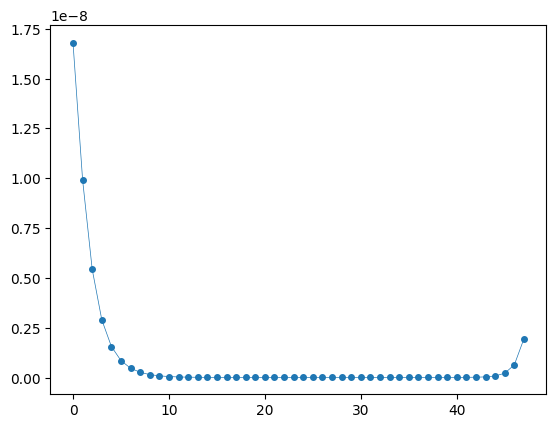

In [161]:
times=np.arange(T)
plt.errorbar(times,corr2p_mean,yerr=corr2p_std, linewidth=0.5,marker='o',markersize=4,elinewidth=1.0)
#plt.yscale('log')

In [162]:
corr2p_std/corr2p_mean
np.mean(np.abs(corr2p_std/corr2p_mean))

array([0.00452719, 0.00518336, 0.00605669, 0.00673011, 0.00727123,
       0.0079051 , 0.00907373, 0.01103739, 0.01417883, 0.01865717,
       0.02539851, 0.03347198, 0.04140545, 0.04954014, 0.06017537,
       0.07389657, 0.0893037 , 0.09597847, 0.09428326, 0.09931617,
       0.09414119, 0.08972729, 0.12397758, 0.12914592, 0.12345702,
       0.09349868, 0.1079634 , 0.12097486, 0.10005403, 0.09593233,
       0.12112013, 0.16288531, 0.15628079, 0.11661141, 0.10875803,
       0.11250681, 0.09630196, 0.0968617 , 0.10687274, 0.09628475,
       0.10092126, 0.09575693, 0.07292878, 0.04436475, 0.02305597,
       0.01225418, 0.00817301, 0.00623049])

np.float64(0.07021732760218816)

In [163]:
#function to be used with the jackknife to compute the effective mass of the correlators
def eff_mass(corr_array: np.ndarray,gauge_axis=0) -> np.ndarray:
    #the input array is the array with the 2point correlators

    #we first take the gauge average
    corr_gavg = np.mean(corr_array, axis=gauge_axis)

    #then we rearrange the array as to have the time as first axis
    #corr_gavg_t = np.moveaxis(corr_gavg, time_axis, 0)

    #for the effective mass the number of time values is Tm1 = T - 1
    #Tm1 = np.shape(corr_gavg_t)[0]-1
    Tm1 = np.shape(corr_gavg)[0]-1

    #we instantiate the eff mass array with first dimension of size tvalues - 1
    #meff = np.zeros(( (Tm1,) + np.shape(corr_gavg_t)[1:] ))
    #"meff"
    #print(np.shape(meff))

    meff = np.empty((Tm1))

    #we compute the effective mass
    for t in range(Tm1):
        #meff[t] = np.log( corr_gavg_t[t]) - np.log( corr_gavg_t[t+1])#np.log( corr_gavg_t[t]/corr_gavg_t[t+1] )
        #meff[t] = np.log(corr_gavg[t]) - np.log(corr_gavg[t+1])
        meff[t] = np.log( (corr_gavg[t]/corr_gavg[t+1]).real )

    #then we bring the time axis back to its position
    #meff = np.moveaxis(meff, 0, time_axis)

    #we send back the effective mass
    return meff

In [197]:
meff_mean, meff_std, meff_cov = jackknife(corr_2p, eff_mass, jack_axis=0)


jack resamples
(102, 101, 48)
obs resamples
(102, 47)
obs
(47,)
jack mean
(47,)
bias
(47,)
obs std
(47,)


<ErrorbarContainer object of 3 artists>

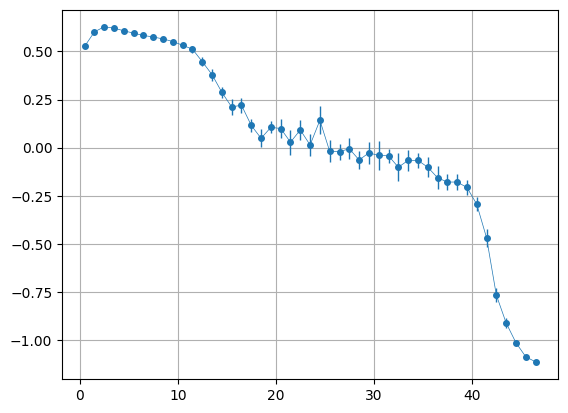

In [165]:
times=np.arange(T)
m_times = times[:-1] +0.5
plt.errorbar(m_times,meff_mean,yerr=meff_std,linewidth=0.5,marker='o',markersize=4,elinewidth=1.0)
plt.grid()

In [166]:
np.shape(corr_2p)

#np.shape( np.rollaxis(corr_2p, -1) )

ok = np.zeros((12,35,77,87))
np.shape(ok)

#np.shape( np.rollaxis( ok , 3) )

ok2 = np.moveaxis( ok , 2, 0)

np.shape( ok2 )

ok3 = np.moveaxis(ok2, 0, 2)

np.shape( ok3 )

(ok3==ok).all()

(102, 48)

(12, 35, 77, 87)

(77, 12, 35, 87)

(12, 35, 77, 87)

np.True_

In [167]:
np.shape(ok)[1:]

ok33 = np.empty(((1,) + (4,67)))

np.shape(ok33)[2]-1

(35, 77, 87)

66

In [168]:
oks = np.ones((10,1,2))
def foo(inarray):
    print(np.shape(inarray))
    return np.zeros(np.shape(inarray))

ttt = np.empty(np.shape(oks))
ttt = np.asarray( [ foo(oks[i]) for i in range(np.shape(oks)[0]) ] )
ttt

(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)


array([[[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]],

       [[0., 0.]]])

(102, 48)

<ErrorbarContainer object of 3 artists>

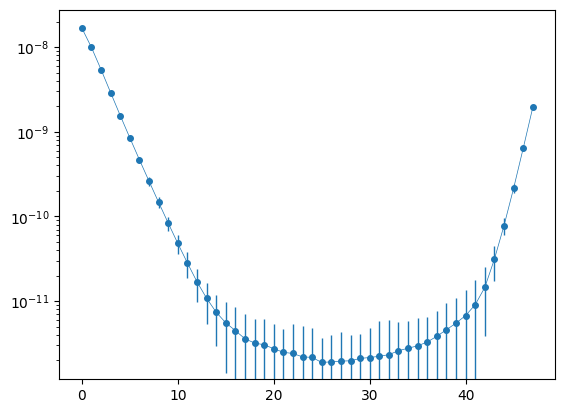

In [169]:
np.shape(corr_2p)

corr_2p_gavg = np.mean(corr_2p,axis=0)
corr_2p_gavg_std = np.std(corr_2p,axis=0)

plt.errorbar(times,corr_2p_gavg,yerr=corr_2p_gavg_std,linewidth=0.5,marker='o',markersize=4,elinewidth=1.0)
plt.yscale('log')
#plt.xlim(0,20)

In [170]:
np.shape(corr_2p_gavg)

(48,)

<ErrorbarContainer object of 3 artists>

(0.0, 48.0)

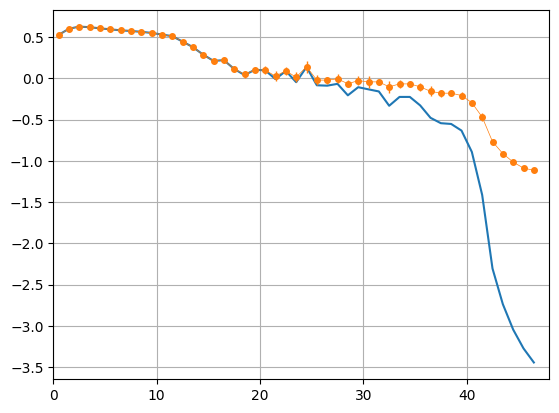

In [ ]:
meff = np.empty((T-1))
for t in range(T-1):
    meff[t] = np.log((corr_2p_gavg[t]/corr_2p_gavg[t+1]).real)

    massa = meff[t]
    for it in range(150):
        den = 1 - np.exp( -2*massa * ( T-t  ) )
        num = 1 - np.exp( -2*massa * ( T-t-1) )
        
        new_massa = np.log( (corr_2p_gavg[t]/corr_2p_gavg[t+1]).real * num/den )

        if np.abs(massa-new_massa)/massa < 3e-10:
                massa=new_massa
                #print(f"{it}")
                break
        massa = new_massa
    meff[t] = massa

tcut = 48
tmin = 0

plt.plot(m_times[tmin:tcut],meff[tmin:tcut])
plt.errorbar(m_times[tmin:tcut],meff_mean[tmin:tcut],yerr=meff_std[tmin:tcut],linewidth=0.5,marker='o',markersize=4,elinewidth=1.0)
plt.grid()
plt.xlim(tmin,tcut)

In [175]:
#auxiliary function to compute the chi2 of a fit
def chi2(array,std_array,axis):
    avg = np.mean(array,axis=axis,keepdims=True)
    return np.sum( ((array-avg)/std_array)**2 , axis=axis) / np.shape(array)[axis]

In [184]:
#algo to search for the plateau value
rcut = 10
lcut = 10
chi2_ref = 1.5
for icut in range(1,int(T/2)):

    plateaux_value = np.mean(meff_mean[icut+lcut:-icut-rcut])
    plateaux_std = np.sqrt( np.mean( meff_mean[icut+lcut:-icut-rcut]**2 ) )

    if chi2(meff_mean[icut+lcut:-icut-rcut],meff_std[icut+lcut:-icut-rcut],axis=0) < chi2_ref:
        chosen_cut = icut
        chosen_cut
        break

9

<ErrorbarContainer object of 3 artists>

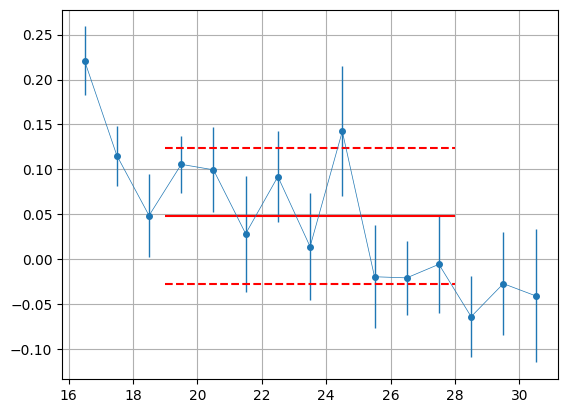

In [185]:
zoom = 3
plt.errorbar(m_times[chosen_cut+lcut -zoom:-chosen_cut-rcut + zoom],meff_mean[chosen_cut+lcut -zoom:-chosen_cut-rcut + zoom],yerr=meff_std[chosen_cut+lcut -zoom:-chosen_cut-rcut + zoom],linewidth=0.5,marker='o',markersize=4,elinewidth=1.0)
plt.hlines(plateaux_value,chosen_cut+lcut, T -1 -chosen_cut-rcut,color='red')
plt.hlines(plateaux_value+plateaux_std,chosen_cut+lcut, T -1 -chosen_cut-rcut,color='red',linestyles='dashed')
plt.hlines(plateaux_value-plateaux_std,chosen_cut+lcut, T -1 -chosen_cut-rcut,color='red',linestyles='dashed')
plt.grid()

In [210]:
#auxiliary function to compute chi2 of a fit taking into account the covariant matrix
def reduced_cov_chi2(array,cov_array,axis):
    cov_inv = np.linalg.inv(cov_array)
    avg = np.mean(array,axis=axis,keepdims=True)
    deltas = array-avg

    plateau_T = np.shape(array)[axis]

    #return np.dot( deltas, np.dot(cov_inv, deltas))

    return np.einsum( 'j,j->' , deltas, np.einsum('jk,k->j',cov_inv,deltas) ) / plateau_T #achtung: indices are not related to general case

In [213]:
#algo to search for the plateau value
rcut = 10
lcut = 10
chi2_ref = 1.0 * 2
for icut in range(1,int(T/2)):

    plateaux_value = np.mean(meff_mean[icut+lcut:-icut-rcut])
    plateaux_std = np.sqrt( np.mean( meff_mean[icut+lcut:-icut-rcut]**2 ) )

    if reduced_cov_chi2(meff_mean[icut+lcut:-icut-rcut],meff_cov[icut+lcut:-icut-rcut,icut+lcut:-icut-rcut],axis=0) < chi2_ref:
        chosen_cut = icut
        chosen_cut
        break

11

<ErrorbarContainer object of 3 artists>

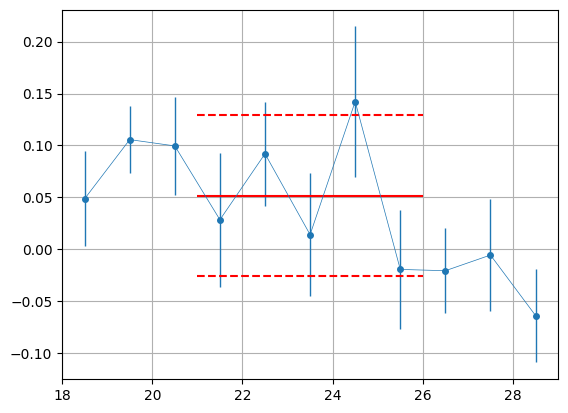

In [214]:
zoom = 3
plt.errorbar(m_times[chosen_cut+lcut -zoom:-chosen_cut-rcut + zoom],meff_mean[chosen_cut+lcut -zoom:-chosen_cut-rcut + zoom],yerr=meff_std[chosen_cut+lcut -zoom:-chosen_cut-rcut + zoom],linewidth=0.5,marker='o',markersize=4,elinewidth=1.0)
plt.hlines(plateaux_value,chosen_cut+lcut, T -1 -chosen_cut-rcut,color='red')
plt.hlines(plateaux_value+plateaux_std,chosen_cut+lcut, T -1 -chosen_cut-rcut,color='red',linestyles='dashed')
plt.hlines(plateaux_value-plateaux_std,chosen_cut+lcut, T -1 -chosen_cut-rcut,color='red',linestyles='dashed')
plt.grid()